<a href="https://colab.research.google.com/github/rohaan2614/var_from_scratch/blob/master/var_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [1]:
!rm -r sample_data

In [2]:
import numpy as np
import gzip
from urllib import request
from tqdm import tqdm
import os

In [3]:
# Constants
url = "https://ossci-datasets.s3.amazonaws.com/mnist/"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

In [4]:
# Create the "data" directory if it doesn't exist
os.makedirs("data", exist_ok=True)

In [5]:
# Download the dataset
for filename in tqdm(filenames, desc="Downloading Dataset"):
    request.urlretrieve(url + filename, os.path.join("data", filename))

In [6]:
# Read dataset
data = []
for filename in os.listdir("data"):
    filepath = os.path.join("data", filename)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28))

In [7]:
print("Data Length: ", len(data), "\ndata: ", data)

Data Length:  4 
data:  [array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)]


# AutoEncoder Class

In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Optional
import torch.nn.functional as F

class VariableAutoEncoder(nn.Module):
    def __init__(self,
                 number_hidden_units : int,
                 encoder : nn.Sequential,
                 decoder : nn.Sequential,
                 train_loader: Optional[DataLoader] = None):
        super().__init__()
        self.num_hidden = number_hidden_units
        self.encoder = encoder
        self.decoder = decoder
        self.train_loader = train_loader
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def set_train_loader(self, train_loader: DataLoader):
        self.train_loader = train_loader

    def forward(self, x):
        encoded = self.encoder(x)

        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)

        decoded = self.decoder(z)
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            z = torch.randn(num_samples, self.num_hidden).to(self.device)
            samples = self.decoder(z)
        return samples

    def describe(self) -> None:
        description = (
            f"AutoEncoder Model\n"
            f"=================\n"
            f"Number of Hidden Units: {self.num_hidden}\n"
            f"Encoder:\n"
            f"{self._describe_sequential(self.encoder)}\n"
            f"Decoder:\n"
            f"{self._describe_sequential(self.decoder)}\n"
        )
        if self.train_loader is not None:
            description += f"Train Loader:\n{self._describe_loader(self.train_loader)}\n"
        print(description)

    def _describe_sequential(self, sequential) -> str:
        layer_descriptions = []
        for i, layer in enumerate(sequential):
            layer_descriptions.append(f"  Layer {i + 1}: {self._describe_layer(layer)}")
        return "\n".join(layer_descriptions)

    def _describe_layer(self, layer) -> str:
        if isinstance(layer, nn.Linear):
            return f"{layer.__class__.__name__} - Input Features: {layer.in_features}, Output Features: {layer.out_features}"
        else:
            return f"{layer.__class__.__name__}"

    def _describe_loader(self, loader: DataLoader) -> str:
        dataset_name = loader.dataset.__class__.__name__
        num_samples = len(loader.dataset)
        num_batches = len(loader)
        return f"  Dataset: {dataset_name}\n  Number of Samples: {num_samples}\n  Number of Batches: {num_batches}"

# Data Transformation

In [9]:
# Split into training and testing sets
X_train, y_train, X_test, y_test = data

In [10]:
print("X_Train: ", X_train)
print("X_Test: ", X_test)

X_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
X_Test:  [7 2 1 ... 4 5 6]


In [11]:
# Normalize the pixel values
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [12]:
print("X_Train: ", X_train)
print("X_Test: ", X_test)

X_Train:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_Test:  [0.02745098 0.00784314 0.00392157 ... 0.01568628 0.01960784 0.02352941]


In [13]:
print("y_Train: ", y_train)
print("y_Test: ", y_test)

y_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_Test:  [5 0 4 ... 5 6 8]


In [14]:
# Convert labels to integers
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [15]:
print("y_Train: ", y_train)
print("y_Test: ", y_test)

y_Train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_Test:  [5 0 4 ... 5 6 8]


In [16]:
# Convert the training data to PyTorch tensors
import torch
X_train = torch.from_numpy(X_train)

In [17]:
# Create a DataLoader to handle batching of the training data
train_loader = torch.utils.data.DataLoader(
    X_train, batch_size=64, shuffle=True
)

In [18]:
number_hidden_units = 8

encoder = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, number_hidden_units),
        nn.ReLU())

decoder = nn.Sequential(
        nn.Linear(number_hidden_units, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid())

# Create AutoEncoder instance
var = VariableAutoEncoder(number_hidden_units=number_hidden_units,
                          encoder=encoder,
                          decoder=decoder,
                          train_loader=train_loader)
# Describe the model
var.describe()

AutoEncoder Model
Number of Hidden Units: 8
Encoder:
  Layer 1: Linear - Input Features: 784, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 8
  Layer 4: ReLU
Decoder:
  Layer 1: Linear - Input Features: 8, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 784
  Layer 4: Sigmoid
Train Loader:
  Dataset: Tensor
  Number of Samples: 10000
  Number of Batches: 157



# Loss Function

In [19]:
def loss_function(recon_x, x, mu, logvar):
    # cross-entropy between the reconstructed output and the input data
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    # Kullback-Leibler divergence with respect to a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [20]:
import torch.optim as optim

num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(var.parameters(), lr=learning_rate)

In [21]:
for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            # Get a batch of training data and move it to the device
            data = data.to(var.device)

            # Forward pass
            encoded, decoded, mu, log_var = var(data)

            # Compute the loss and perform backpropagation
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(decoded, data) + 3 * KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

Epoch 1/10: loss=7.8934
Epoch 2/10: loss=0.1688
Epoch 3/10: loss=0.1022
Epoch 4/10: loss=0.0882
Epoch 5/10: loss=0.0826
Epoch 6/10: loss=0.0800
Epoch 7/10: loss=0.0778
Epoch 8/10: loss=0.0769
Epoch 9/10: loss=0.0755
Epoch 10/10: loss=0.0745


# Visualize

### Reconstructed

In [22]:
# Move tensor to CPU and convert to numpy array
reconstructed_images = decoded.cpu().detach().numpy()
len(reconstructed_images)

16

In [23]:
# Reshape the pixel values into images
num_channels = 1
height = 28
width = 28
reconstructed_images = reconstructed_images.reshape(len(reconstructed_images), num_channels, height, width)
len(reconstructed_images), reconstructed_images.shape

(16, (16, 1, 28, 28))

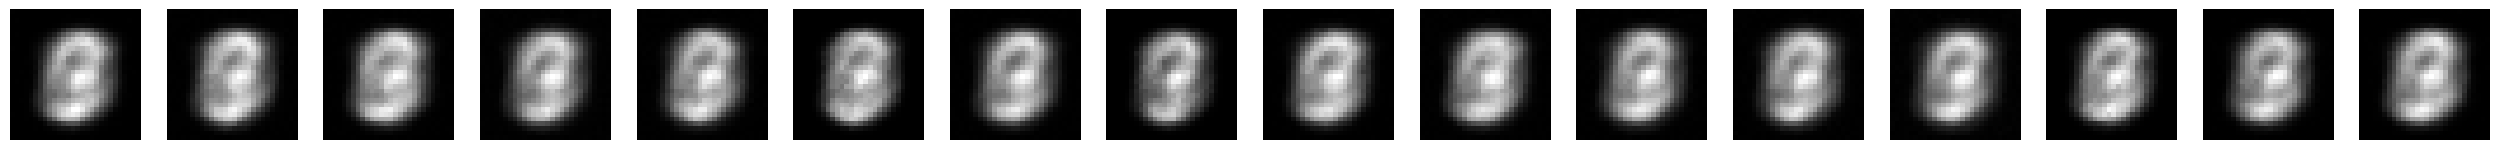

In [24]:
import matplotlib.pyplot as plt

# Plot the reconstructed images
fig, axes = plt.subplots(nrows=1, ncols=len(reconstructed_images), figsize=(len(reconstructed_images) * 2, 2))
for i in range(len(reconstructed_images)):
    if num_channels == 1:
        axes[i].imshow(reconstructed_images[i][0], cmap='gray')
    else:
        axes[i].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
    axes[i].axis('off')
plt.show()

### Original vs Reconstructed

In [25]:
# Move tensor to CPU and convert to numpy array
original_images = data.cpu().detach().numpy()
len(original_images)

16

In [26]:
# Reshape the pixel values into images
original_images = original_images.reshape(len(original_images), num_channels, height, width)
len(original_images), original_images.shape

(16, (16, 1, 28, 28))

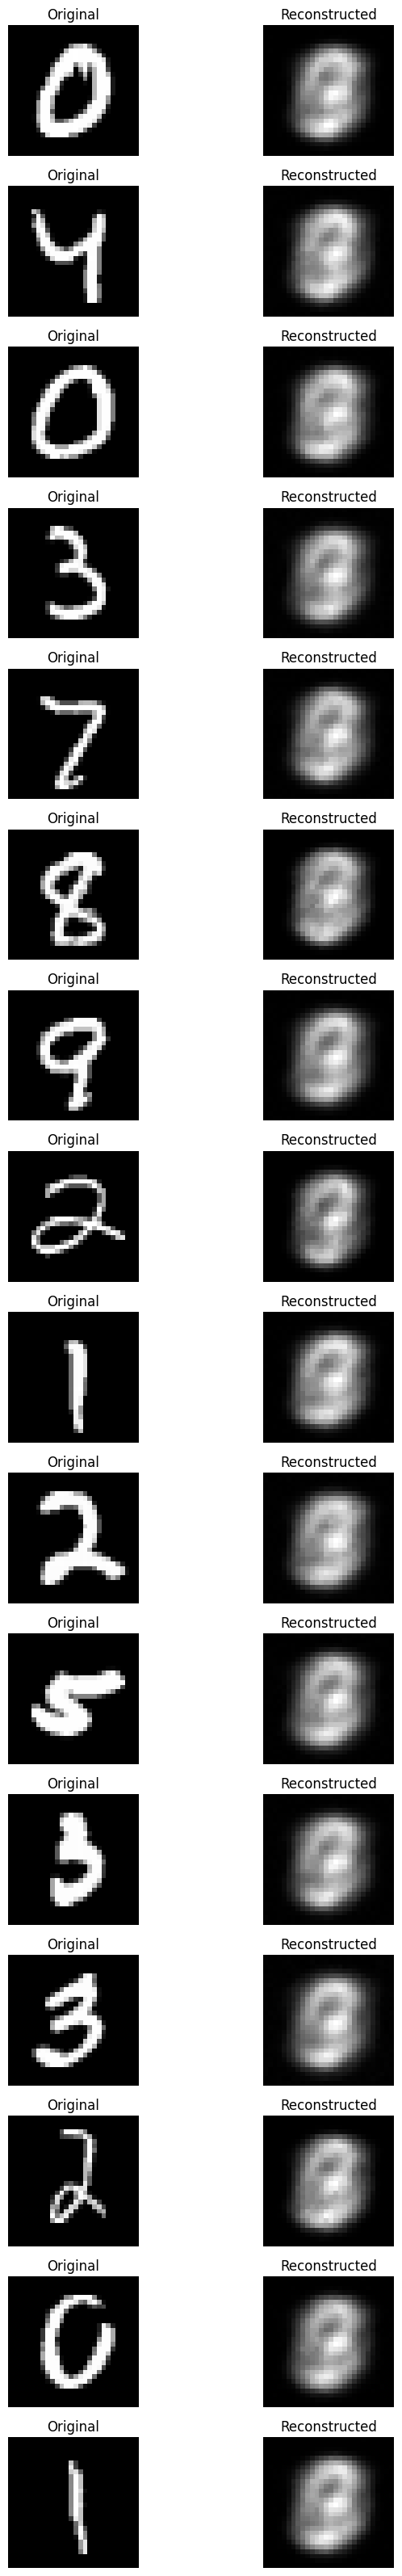

In [27]:
fig, axes = plt.subplots(nrows=len(original_images), ncols=2, figsize=(8, len(original_images) * 2))
for i in range(len(original_images)):
    # Plot original image
    if num_channels == 1:
        axes[i, 0].imshow(original_images[i][0], cmap='gray')
    else:
        axes[i, 0].imshow(np.transpose(original_images[i], (1, 2, 0)))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Plot reconstructed image
    if num_channels == 1:
        axes[i, 1].imshow(reconstructed_images[i][0], cmap='gray')
    else:
        axes[i, 1].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Generate Novel Images

In [28]:
# Using a more trained version
number_hidden_units = 16

encoder = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, number_hidden_units),
        nn.ReLU())

decoder = nn.Sequential(
        nn.Linear(number_hidden_units, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid())

# Create AutoEncoder instance
var2 = VariableAutoEncoder(number_hidden_units=number_hidden_units,
                          encoder=encoder,
                          decoder=decoder,
                          train_loader=train_loader)
# Describe the model
var2.describe()

AutoEncoder Model
Number of Hidden Units: 16
Encoder:
  Layer 1: Linear - Input Features: 784, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 16
  Layer 4: ReLU
Decoder:
  Layer 1: Linear - Input Features: 16, Output Features: 256
  Layer 2: ReLU
  Layer 3: Linear - Input Features: 256, Output Features: 784
  Layer 4: Sigmoid
Train Loader:
  Dataset: Tensor
  Number of Samples: 10000
  Number of Batches: 157



In [29]:
num_epochs = 100
learning_rate = 0.001
batch_size = 32

print("lr: ", learning_rate)

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(var2.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(var2.device)

            # Forward pass
            encoded, decoded, mu, log_var = var2(data)

            # Compute the loss and perform backpropagation
            KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(decoded, data) + 3 * KLD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

lr:  0.001
Epoch 1/100: loss=8.1447
Epoch 2/100: loss=0.1992
Epoch 3/100: loss=0.1372
Epoch 4/100: loss=0.1233
Epoch 5/100: loss=0.1014
Epoch 6/100: loss=0.0933
Epoch 7/100: loss=0.0874
Epoch 8/100: loss=0.0832
Epoch 9/100: loss=0.0807
Epoch 10/100: loss=0.0809
Epoch 11/100: loss=0.0844
Epoch 12/100: loss=0.0865
Epoch 13/100: loss=0.0890
Epoch 14/100: loss=0.0744
Epoch 15/100: loss=0.0720
Epoch 16/100: loss=0.0721
Epoch 17/100: loss=0.0725
Epoch 18/100: loss=0.0790
Epoch 19/100: loss=0.0720
Epoch 20/100: loss=0.0718
Epoch 21/100: loss=0.0712
Epoch 22/100: loss=0.0704
Epoch 23/100: loss=0.0728
Epoch 24/100: loss=0.0706
Epoch 25/100: loss=0.0706
Epoch 26/100: loss=0.0719
Epoch 27/100: loss=0.0716
Epoch 28/100: loss=0.0717
Epoch 29/100: loss=0.0703
Epoch 30/100: loss=0.0705
Epoch 31/100: loss=0.0700
Epoch 32/100: loss=0.0694
Epoch 33/100: loss=0.0706
Epoch 34/100: loss=0.0703
Epoch 35/100: loss=0.0689
Epoch 36/100: loss=0.0687
Epoch 37/100: loss=0.0687
Epoch 38/100: loss=0.0693
Epoch 39/1

In [30]:
num_samples = 16
generated_samples = var2.sample(num_samples)
generated_samples

tensor([[0.0005, 0.0005, 0.0004,  ..., 0.0004, 0.0005, 0.0005],
        [0.0004, 0.0003, 0.0003,  ..., 0.0004, 0.0003, 0.0003],
        [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0008],
        ...,
        [0.0008, 0.0007, 0.0007,  ..., 0.0007, 0.0008, 0.0008],
        [0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0004, 0.0003],
        [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006]])

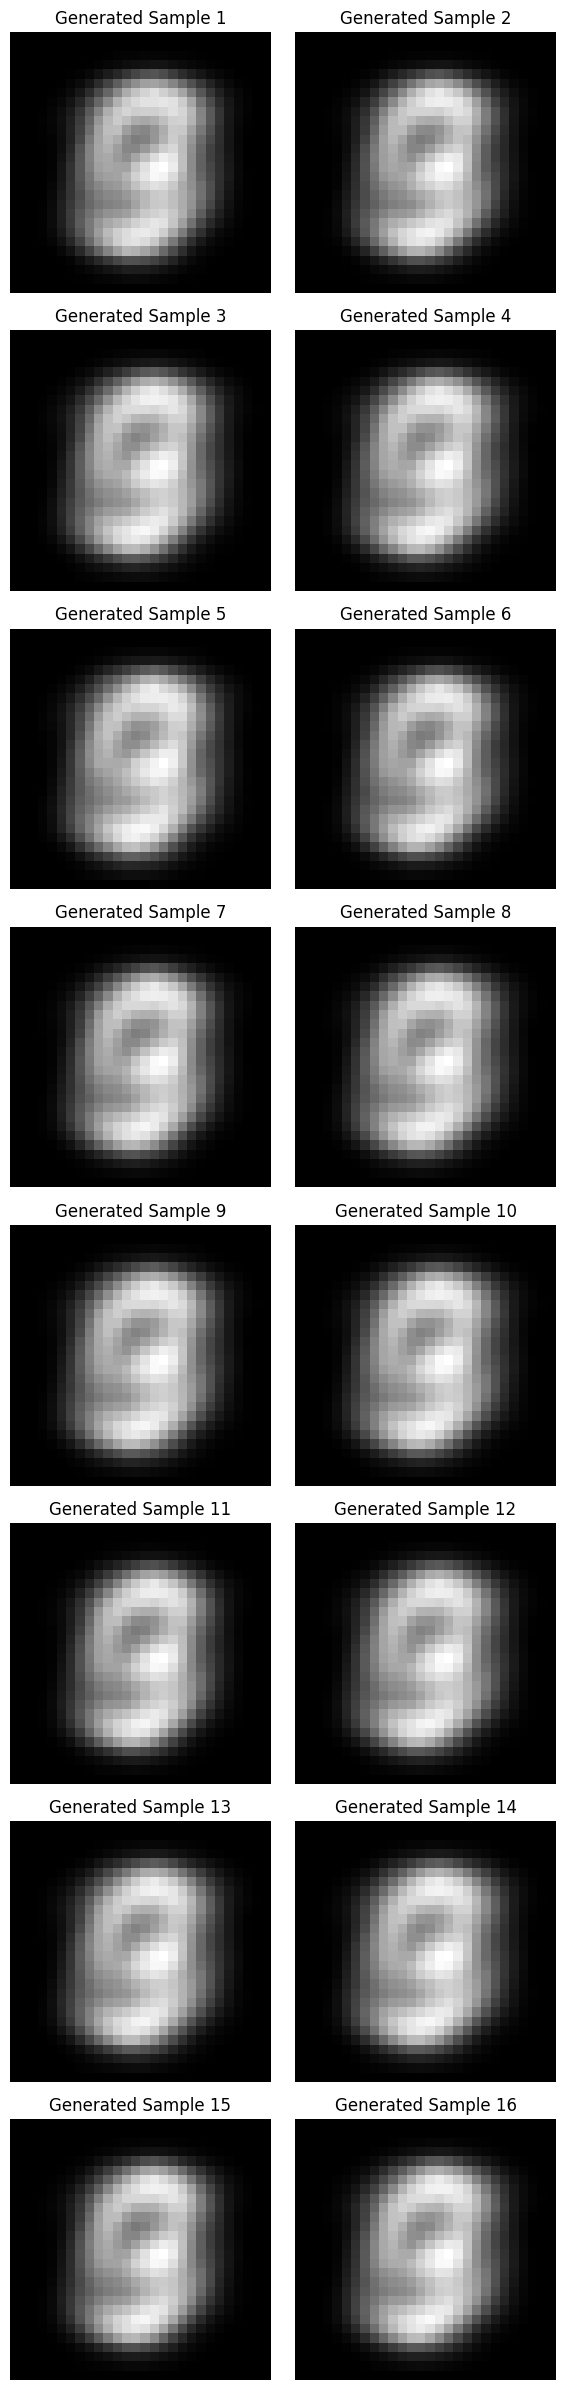

In [33]:
images_per_row = 2

num_rows = (num_samples + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(nrows=num_rows, ncols=images_per_row, figsize=(6, 3 * num_rows))
for i in range(num_rows):
    for j in range(images_per_row):
        index = i * images_per_row + j
        if index < num_samples:
            axes[i, j].imshow(generated_samples[index].view(28, 28), cmap='gray')
            axes[i, j].set_title(f"Generated Sample {index+1}")
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()